In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import requests
from bs4 import BeautifulSoup
import json
import numpy as np
import pandas as pd
import math
import time
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
import pickle

Mounted at /content/drive


In [ ]:
# 카멘 하드 3 관문 데이터
base_url='https://logs.fau.dev/api/logs?scope=arkesia&order=recent%20clear'

params = {
"raids": {
"Thaemine": {
"gates": [3],
"difficulties": ['Hard']}
},
"guardians": [],
"trials": [],
"classes": [],
"search": ""
}

r = requests.post(base_url, json=params)
json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)

Thaemine_Hard_3 = []
count=0

while json_data['more']:
  time.sleep(0.2)
  encounter_id = [encounter['id'] for encounter in json_data['encounters']]
  encounter_date = [encounter['date'] for encounter in json_data['encounters']]
  encounter_place = [encounter['place'] for encounter in json_data['encounters']]
  Thaemine_Hard_3.extend(encounter_id)
  add_url = f'https://logs.fau.dev/api/logs?scope=arkesia&past_id={encounter_id[-1]}&past_place={encounter_place[-1]}&past_field={encounter_date[-1]}&order=recent%20clear'
  r = requests.post(add_url, json=params)
  json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)
  count+=1

In [ ]:
with open('/content/drive/MyDrive/Thaemine_Hard_3.csv', 'wb') as f:
    pickle.dump(Thaemine_Hard_3, f)

with open('/content/drive/MyDrive/Thaemine_Hard_3', 'wb') as f:
    pickle.dump(Thaemine_Hard_3, f)

NameError: name 'Thaemine_Hard_3' is not defined

In [ ]:
# 카멘 하드 4 관문 데이터
base_url='https://logs.fau.dev/api/logs?scope=arkesia&order=recent%20clear'

params = {
"raids": {
"Thaemine": {
"gates": [4],
"difficulties": ['Hard']}
},
"guardians": [],
"trials": [],
"classes": [],
"search": ""
}

r = requests.post(base_url, json=params)
json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)

Thaemine_Hard_4 = []
count=0

while json_data['more']:
  time.sleep(0.2)
  encounter_id = [encounter['id'] for encounter in json_data['encounters']]
  encounter_date = [encounter['date'] for encounter in json_data['encounters']]
  encounter_place = [encounter['place'] for encounter in json_data['encounters']]
  Thaemine_Hard_4.extend(encounter_id)
  add_url = f'https://logs.fau.dev/api/logs?scope=arkesia&past_id={encounter_id[-1]}&past_place={encounter_place[-1]}&past_field={encounter_date[-1]}&order=recent%20clear'
  r = requests.post(add_url, json=params)
  json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)
  count+=1

In [ ]:
with open('/content/drive/MyDrive/Thaemine_Hard_4.csv', 'wb') as f:
    pickle.dump(Thaemine_Hard_4, f)

with open('/content/drive/MyDrive/Thaemine_Hard_4', 'wb') as f:
    pickle.dump(Thaemine_Hard_4, f)

In [ ]:
Main_df=pd.DataFrame()
synergy_df=pd.DataFrame()
count=0

for k in Thaemine_Hard_3:
  #카멘 데이터
  encounter_url = f'https://logs.fau.dev/api/log/{k}'
  encounter_json = json.loads(BeautifulSoup(requests.get(encounter_url).text, 'html.parser').text)

  #시너지 있는 df 만들기
  for i in encounter_json['data']['players'].keys():
    temp_df = pd.DataFrame.from_dict(encounter_json['data']['players'][i]['synergy'], orient='index')
    synergy_df=pd.concat([synergy_df,temp_df],axis=0)

  # 직업 리스트(# 없는 정제버전)
  job=[]
  for cl in list(encounter_json['players'].keys()):
    try:
      job.append(cl[:cl.index('#')].strip())
    except:
      job.append(cl.strip())

  #직업별 메인 스킬 코드>>차후 직각 분류에 사용
  main_skill=[max(encounter_json['data']['players'][i]['skillDamage'],key=lambda k:encounter_json['data']['players'][i]['skillDamage'][k]['damage'])for i in encounter_json['data']['players'].keys() ]


  #8인 dps
  dps=[encounter_json['players'][i]['dps'] for i in encounter_json['players'].keys()]

  #누군가 죽었는지 알아보기 , json 자리에는 list(encounter_json['players'].keys()) 입력
  def die (json):
    for i in json:
      if encounter_json['players'][i]['dead']:
        return 1
        break
    return 0

  die_TF=die(list(encounter_json['players'].keys()))

  #템렙(버림값)
  gearScore=[math.floor(encounter_json['players'][i]['gearScore'])for i in encounter_json['data']['players'].keys() ]

  #관문명
  boss=encounter_json['boss']

  #난이도
  difficulty=encounter_json['difficulty']

  #df 만들기
  df = pd.DataFrame({
      'dps': dps,
      'main_skill': main_skill,
      'gearScore': gearScore,
      'die_TF': die_TF,
      'boss': boss,
      'difficulty': difficulty
  })
  df.index=job

  df['1630_dps']=[int(df['dps'].iloc[i]/(1.00584**(df['gearScore'].iloc[i]-1630))) for i in range(df.shape[0])]

  Main_df=pd.concat([Main_df,df],axis=0)

  count+=1

#시너지 df 계산 위해percent 숫자형으로 바꾸기
synergy_df['percent']=synergy_df['percent'].astype(float)

#index 초기화해서 name column 만들기
synergy_df.reset_index(inplace=True)
synergy_df.rename(columns={'index': 'name'}, inplace=True)

synergy= pd.DataFrame(synergy_df.groupby('name')['percent'].mean())

Main_df.reset_index(inplace=True)
Main_df.rename(columns={'index': 'class'}, inplace=True)

synergy.reset_index(inplace=True)
synergy.rename(columns={'index': 'skill_name'}, inplace=True)

#저장
Main_df.to_feather('/content/drive/MyDrive/Thaemine_Hard_3_df.feather')
synergy.to_feather('/content/drive/MyDrive/Thaemine_Hard_3_synergy.feather')

,class,dps,main_skill,gearScore,die_TF,boss,difficulty,1630_dps
0,Deathblade,31644577,25038,1634,1,Thaemine the Lightqueller,Hard,30916027
1,Deathblade,9462939,25038,1638,1,Thaemine the Lightqueller,Hard,9032226
2,Paladin,160497,36060,1630,1,Thaemine the Lightqueller,Hard,160497
3,Slayer,28996570,45004,1634,1,Thaemine the Lightqueller,Hard,28328985
4,Snowis,858290,607016240,1638,1,Thaemine the Lightqueller,Hard,819224
...,...,...,...,...,...,...,...,...
24689,Gunslinger,22565968,38110,1633,1,Thaemine the Lightqueller,Hard,22175185
24690,Paladin,192691,36080,1630,1,Thaemine the Lightqueller,Hard,192691
24691,Slayer,22440105,45730,1642,1,Thaemine the Lightqueller,Hard,20925606
24692,Souleater,29965621,46520,1633,1,Thaemine the Lightqueller,Hard,29446696


In [ ]:
Main_df=pd.DataFrame()
synergy_df=pd.DataFrame()
count=0

for k in Thaemine_Hard_4:
  #카멘 데이터
  encounter_url = f'https://logs.fau.dev/api/log/{k}'
  encounter_json = json.loads(BeautifulSoup(requests.get(encounter_url).text, 'html.parser').text)

  #시너지 있는 df 만들기
  for i in encounter_json['data']['players'].keys():
    temp_df = pd.DataFrame.from_dict(encounter_json['data']['players'][i]['synergy'], orient='index')
    synergy_df=pd.concat([synergy_df,temp_df],axis=0)

  # 직업 리스트(# 없는 정제버전)
  job=[]
  for cl in list(encounter_json['players'].keys()):
    try:
      job.append(cl[:cl.index('#')].strip())
    except:
      job.append(cl.strip())

  #직업별 메인 스킬 코드>>차후 직각 분류에 사용
  main_skill=[max(encounter_json['data']['players'][i]['skillDamage'],key=lambda k:encounter_json['data']['players'][i]['skillDamage'][k]['damage'])for i in encounter_json['data']['players'].keys() ]


  #8인 dps
  dps=[encounter_json['players'][i]['dps'] for i in encounter_json['players'].keys()]

  #누군가 죽었는지 알아보기 , json 자리에는 list(encounter_json['players'].keys()) 입력
  def die (json):
    for i in json:
      if encounter_json['players'][i]['dead']:
        return 1
        break
    return 0

  die_TF=die(list(encounter_json['players'].keys()))

  #템렙(버림값)
  gearScore=[math.floor(encounter_json['players'][i]['gearScore'])for i in encounter_json['data']['players'].keys() ]

  #관문명
  boss=encounter_json['boss']

  #난이도
  difficulty=encounter_json['difficulty']

  #df 만들기
  df = pd.DataFrame({
      'dps': dps,
      'main_skill': main_skill,
      'gearScore': gearScore,
      'die_TF': die_TF,
      'boss': boss,
      'difficulty': difficulty
  })
  df.index=job

  df['1630_dps']=[int(df['dps'].iloc[i]/(1.00584**(df['gearScore'].iloc[i]-1630))) for i in range(df.shape[0])]

  Main_df=pd.concat([Main_df,df],axis=0)

  count+=1

#시너지 df 계산 위해percent 숫자형으로 바꾸기
synergy_df['percent']=synergy_df['percent'].astype(float)

#index 초기화해서 name column 만들기
synergy_df.reset_index(inplace=True)
synergy_df.rename(columns={'index': 'name'}, inplace=True)

synergy= pd.DataFrame(synergy_df.groupby('name')['percent'].mean())

Main_df.reset_index(inplace=True)
Main_df.rename(columns={'index': 'class'}, inplace=True)

synergy.reset_index(inplace=True)
synergy.rename(columns={'index': 'skill_name'}, inplace=True)

#저장
Main_df.to_feather('/content/drive/MyDrive/Thaemine_Hard_4_df.feather')
synergy.to_feather('/content/drive/MyDrive/Thaemine_Hard_4_synergy.feather')

In [ ]:
# 데이터 불러오기
Main_df=pd.read_feather('/content/drive/MyDrive/Thaemine_Hard_3_df.feather')
synergy=pd.read_feather('/content/drive/MyDrive/Thaemine_Hard_3_synergy.feather')

In [ ]:
# 데이터 불러오기
Main_df=pd.read_feather('/content/drive/MyDrive/Thaemine_Hard_4_df.feather')
synergy=pd.read_feather('/content/drive/MyDrive/Thaemine_Hard_4_synergy.feather')

In [ ]:
Main_df['main_skill']=Main_df['main_skill'].astype(int)
main_skill=list(Main_df['main_skill'].unique())
class_name=list(Main_df['class'].unique())

In [ ]:
main_skill_class_dic={}
class_main_skill_dic={}

for i in main_skill:
  k=Main_df[Main_df['main_skill']==i]['class'].mode().iloc[0]

  main_skill_class_dic[i]=k

  if k in class_main_skill_dic:
    class_main_skill_dic[k].append(i)
  else:
    class_main_skill_dic[k]=[i]   #딕셔너리 만들때 value를 list 형태로 안만들어 두면 append 할때 머리가 아프다!!


In [ ]:
filtered_df = Main_df.groupby('main_skill').filter(lambda x: len(x) > 30)

In [ ]:
a=filtered_df.groupby(['class','main_skill']).size().reset_index(name='count')
a=a[a['count']>30]

In [ ]:
a['class'].unique()

array(['Aeromancer', 'Arcanist', 'Artillerist', 'Artist', 'Bard',
       'Berserker', 'Breaker', 'Deadeye', 'Deathblade', 'Destroyer',
       'Glaivier', 'Gunlancer', 'Gunslinger', 'Machinist', 'Paladin',
       'Reaper', 'Scrapper', 'Shadowhunter', 'Sharpshooter', 'Slayer',
       'Sorceress', 'Souleater', 'Soulfist', 'Striker', 'Summoner',
       'Wardancer'], dtype=object)

In [ ]:
top_n_df = a.groupby('class').apply(lambda x: x.nlargest(2, 'count')).reset_index(drop=True)

,class,main_skill,count
0,Aeromancer,32260,142
1,Aeromancer,32250,123
2,Arcanist,19140,334
3,Arcanist,19050,326
4,Artillerist,30260,181
5,Artillerist,30270,167
6,Artist,607016240,925
7,Artist,607016230,171
8,Bard,607016240,1933
9,Bard,607016230,328


In [ ]:
list(top_n_df['class'].unique())

['Aeromancer',
 'Arcanist',
 'Artillerist',
 'Artist',
 'Bard',
 'Berserker',
 'Breaker',
 'Deadeye',
 'Deathblade',
 'Destroyer',
 'Glaivier',
 'Gunlancer',
 'Gunslinger',
 'Machinist',
 'Paladin',
 'Reaper',
 'Scrapper',
 'Shadowhunter',
 'Sharpshooter',
 'Slayer',
 'Sorceress',
 'Souleater',
 'Soulfist',
 'Striker',
 'Summoner',
 'Wardancer']

In [ ]:
class_2_main_skill_dic={}

for i in list(top_n_df['class'].unique()):
  class_2_main_skill_dic[i]=list(top_n_df[top_n_df['class']==i]['main_skill'])

{'Aeromancer': [32260, 32250],
 'Arcanist': [19140, 19050],
 'Artillerist': [30260, 30270],
 'Artist': [607016240, 607016230],
 'Bard': [607016240, 607016230],
 'Berserker': [16640, 16300],
 'Breaker': [47020, 47270],
 'Deadeye': [29300, 29290],
 'Deathblade': [25038, 25402],
 'Destroyer': [18170, 18030],
 'Glaivier': [34590, 34110],
 'Gunlancer': [17200, 17140],
 'Gunslinger': [38110, 38240],
 'Machinist': [35210, 35800],
 'Paladin': [607016240, 607016230],
 'Reaper': [26810],
 'Scrapper': [23220, 23110],
 'Shadowhunter': [27860, 27180],
 'Sharpshooter': [28220],
 'Slayer': [45730, 45004],
 'Sorceress': [37350, 37280],
 'Souleater': [46520],
 'Soulfist': [24210, 24200],
 'Striker': [39100, 39040],
 'Summoner': [20311],
 'Wardancer': [22340, 22320]}

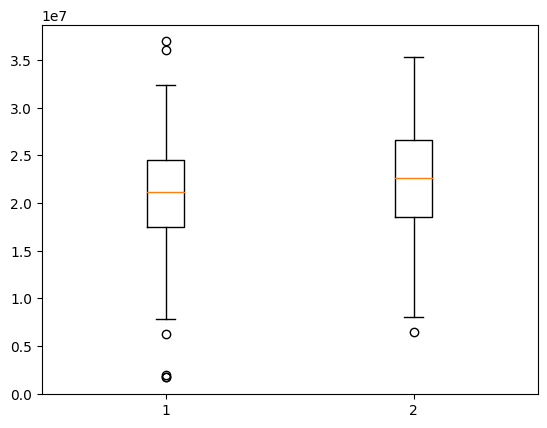

In [ ]:
plt.boxplot([filtered_df[filtered_df['main_skill']==i]['1630_dps'] for i in class_2_main_skill_dic['Destroyer']])
plt.show()

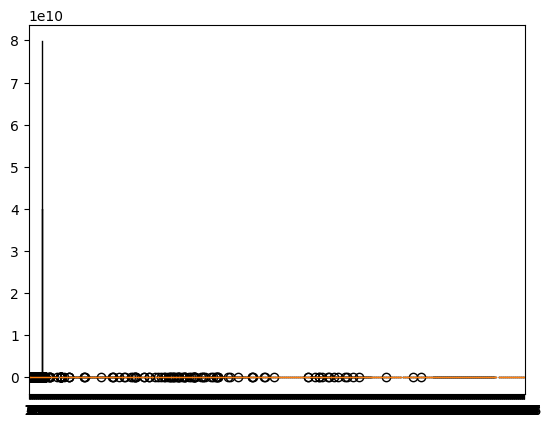

['Deathblade',
 'Paladin',
 'Slayer',
 'Snowis',
 'Sorceress',
 'Soulfist',
 'Wardancer',
 'Artist',
 'Breaker',
 'Scyllanist',
 'Souleater',
 'Anakngkamote',
 'Aniaangle',
 'Annuli',
 'Curax',
 'Thraxkun',
 'Velodi',
 'Vezjr',
 'Yolopunch',
 'Arcanist',
 'Bard',
 'Berserker',
 'Deadeye',
 'Reaper',
 'Scyllarr',
 'Adsèm',
 'Gunlancer',
 'Sharpshooter',
 'Gunslinger',
 'Hollowtttt',
 'Scrapper',
 'Shadowhunter',
 'Scyllayer',
 'Artillerist',
 'Striker',
 'Paranoidandroid',
 'Glaivier',
 'Destroyer',
 'Mugetsus',
 'Zaregoto',
 'Aeromancer',
 'Scyllard',
 'Paranoidslayroid',
 'Kirisame',
 'Pusheens',
 'Qiaokèli',
 'Ainhammer',
 'Boobau',
 'Frogsprinkler',
 'Icemanmage',
 'Jînnie',
 'Ransumasuta',
 'Ryk',
 'Tatcha',
 'Machinist',
 'Avgilykos',
 'Baang',
 'Itsyuboidom',
 'Mokomcflash',
 'Octoberstar',
 'Purpleclue',
 'Warscythë',
 'Yuushuta',
 'Chaehorn',
 'Masterching',
 'Mirajanee',
 'Ryyk',
 'Souru',
 'Vaccines',
 'Yeetdemon',
 'Calancea',
 'Silentwarior',
 'Dudebreaker',
 'Hoyeah',
 'Pa